In [260]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/Marketing_Prediction")

data = pd.read_csv("data.csv", na_values=["", "NA"])

In [261]:
import pandas as pd
import numpy as np

# Replace missing or empty values in columns 4, 5, 6 with "unknown"
data.iloc[:, [3, 4, 5]] = data.iloc[:, [3, 4, 5]].applymap(lambda x: "unknown" if pd.isna(x) or x == "" else x)

# Replace income with appropriate midpoints or custom values
income_mapping = {
    "unknown": 6,              # replacing unknown with the median income level
    "Under $10k": 1,            # midpoint of "Under $10k"
    "10-19,999": 2,            # midpoint of "10-19,999"
    "20-29,999": 3,            # midpoint of "20-29,999"
    "30-39,999": 4,            # midpoint of "30-39,999"
    "40-49,999": 5,            # midpoint of "40-49,999"
    "50-59,999": 6,            # midpoint of "50-59,999"
    "60-69,999": 7,            # midpoint of "60-69,999"
    "70-79,999": 8,            # midpoint of "70-79,999"
    "80-89,999": 9,            # midpoint of "80-89,999"
    "90-99,999": 10,            # midpoint of "90-99,999"
    "100-149,999": 11,         # midpoint of "100-149,999"
    "150 - 174,999": 12,       # midpoint of "150 - 174,999"
    "175 - 199,999": 13,       # midpoint of "175 - 199,999"
    "200 - 249,999": 14,       # midpoint of "200 - 249,999"
    "250k+": 15               # custom value for "250k+"
}
data["income"] = data["income"].map(income_mapping).astype(int)

# Replace gender with 1 for male, 0 for female, and 0 for unknown
gender_mapping = {"M": 1, "F": 0, "unknown": 0}
data["gender"] = data["gender"].map(gender_mapping).astype(int)

# Replace marital_status with 1 for married, 0 for single, and 1 for unknown
marital_status_mapping = {"M": 1, "S": 0, "unknown": 1}
data["marital_status"] = data["marital_status"].map(marital_status_mapping).astype(int)

# Convert target to categorical values (0 or 1)
data["target"] = data["target"].astype(int)

# Convert distance (dist) column to integer
data["dist"] = data["dist"].astype(int)

/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_6910/2211222545.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data.iloc[:, [3, 4, 5]] = data.iloc[:, [3, 4, 5]].applymap(lambda x: "unknown" if pd.isna(x) or x == "" else x)


In [262]:
display(data.head())

,id,age,dist,income,gender,marital_status,target
0,1,73,4,10,1,0,1
1,2,89,1,11,1,1,1
2,3,85,1,2,0,0,1
3,4,76,2,10,1,1,1
4,5,76,2,2,1,0,1


We want to build a Binary Classifier model. Let's build a Logistic Regression and do some preliminary diagnostic to see if such a model would be appropiate for our give data. 

In [263]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictor = data[['age', 'dist', 'income','gender','marital_status']] 
response = data['target']  

model = LogisticRegression()
model.fit(predictor, response) 

LogisticRegression()

Check our model summary 

distance is insignifigant 

In [264]:
import statsmodels.api as sm

predictor = data[['age', 'income','dist', 'gender', 'marital_status']]
response = data['target']

predictor_with_const = sm.add_constant(predictor)

logit_model = sm.Logit(response, predictor_with_const)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.527865
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 4000
Model:                          Logit   Df Residuals:                     3994
Method:                           MLE   Df Model:                            5
Date:                Wed, 18 Dec 2024   Pseudo R-squ.:                 0.06130
Time:                        15:00:49   Log-Likelihood:                -2111.5
converged:                       True   LL-Null:                       -2249.3
Covariance Type:            nonrobust   LLR p-value:                 1.619e-57
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.3820      0.401    -10.915      0.000      -5.169      -3.595
age              

The Pseudo R-square isn't great, let's check out the Logit plots of our predictors as they all reject the null that they equal zero.

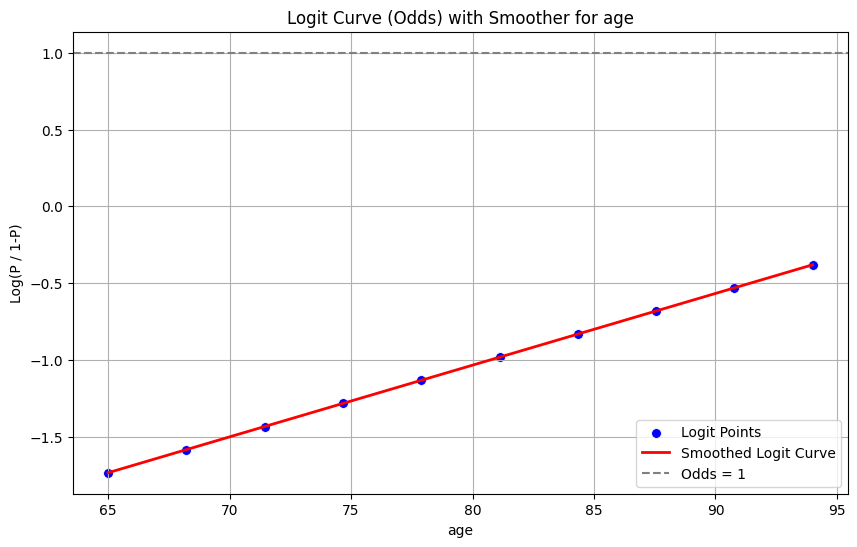

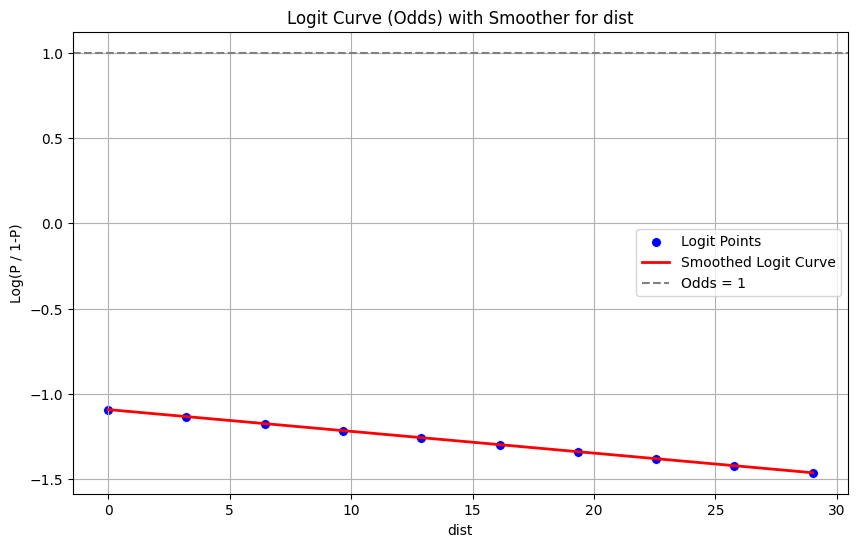

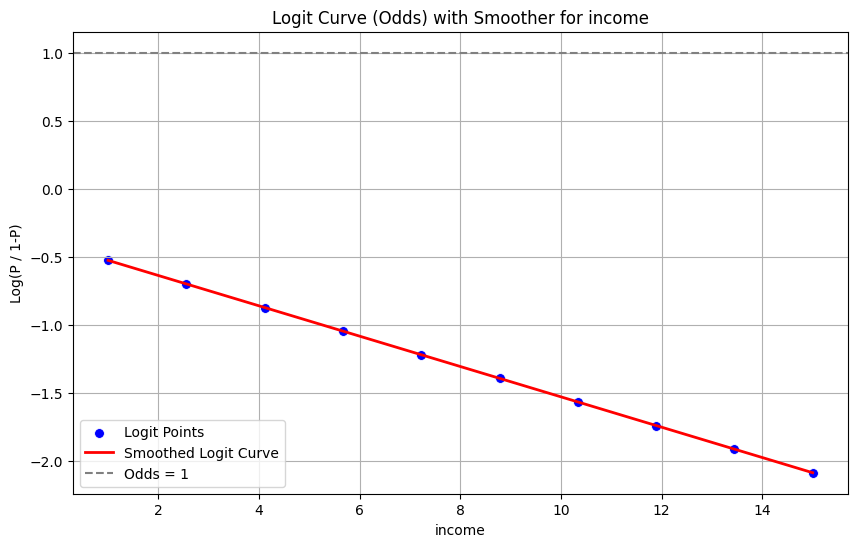

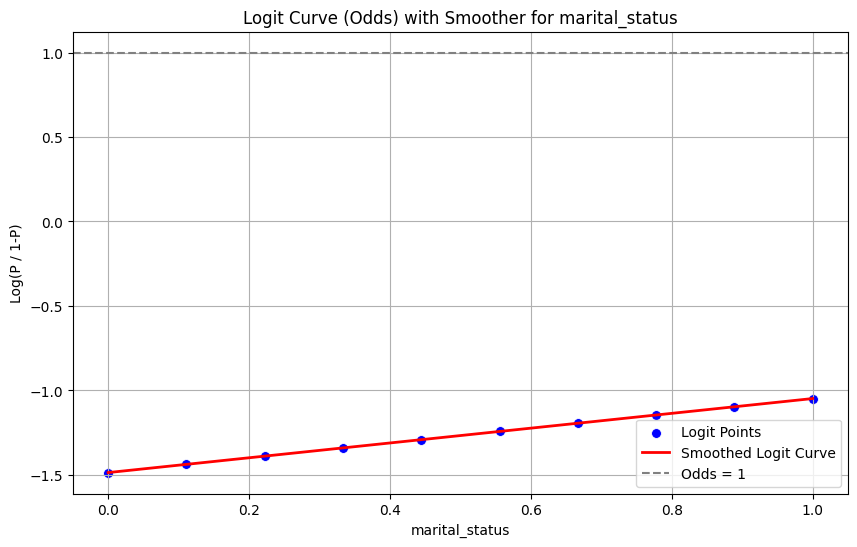

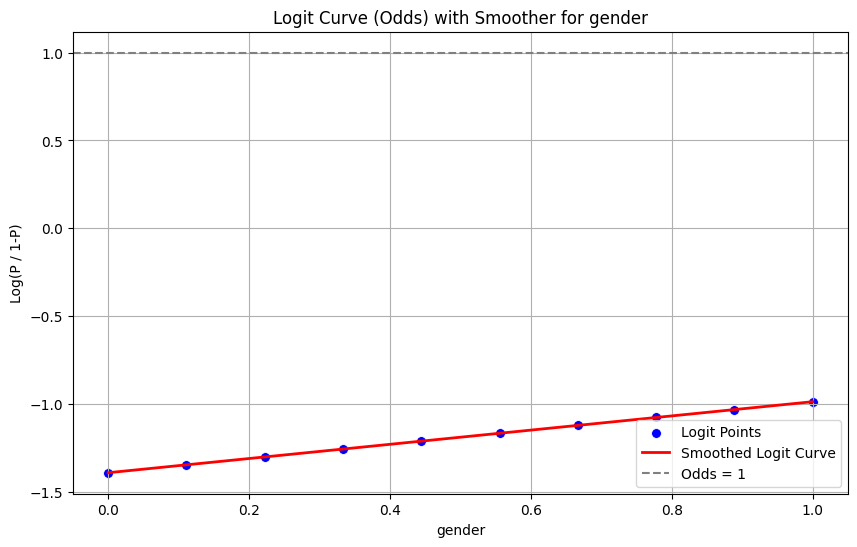

In [265]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def plot_logit_curve_with_smoother(result, predictor, feature_name):
    """
    Plot the logit curve (odds) for a given feature with scatter points and a smoother.

    Parameters:
    - result: Fitted logistic regression model.
    - predictor: Training dataset of predictors.
    - feature_name: The feature for which to plot the logit curve.
    """
    # Generate a range of values for the selected feature
    feature_values = np.linspace(predictor[feature_name].min(), predictor[feature_name].max(), 10)
    
    # Keep other predictors fixed at their mean
    fixed_predictors = predictor.mean(axis=0).copy()
    
    # Calculate the logit (odds) for each feature value
    log_odds = []
    for value in feature_values:
        temp_predictors = fixed_predictors.copy()
        temp_predictors[feature_name] = value
        
        # Add constant and ensure shape matches model coefficients
        predictors_with_const = sm.add_constant(temp_predictors.values.reshape(1, -1), has_constant='add')
        logit = np.dot(predictors_with_const, result.params)
        #odds = np.exp(logit)  this is ploting the log(p/1-p) i just ommited the exp()
        log_odds.append(logit[0])
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        feature_name: feature_values,
        'log_odds': log_odds
    })
    
    # Plot the logit curve with points and smoother
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature_name, y='log_odds', data=plot_df, color='blue', s=50, label='Logit Points')
    sns.regplot(x=feature_name, y='log_odds', data=plot_df, scatter=False, lowess=True, 
                color='red', line_kws={'lw': 2}, label='Smoothed Logit Curve')
    
    plt.title(f'Logit Curve (Odds) with Smoother for {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Log(P / 1-P)')
    plt.axhline(1, color='grey', linestyle='--', label='Odds = 1')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
plot_logit_curve_with_smoother(result, predictor, 'age')
plot_logit_curve_with_smoother(result, predictor, 'dist')
plot_logit_curve_with_smoother(result, predictor, 'income')
plot_logit_curve_with_smoother(result, predictor, 'marital_status')
plot_logit_curve_with_smoother(result, predictor, 'gender')



These are incredibly weak predictors. Are these variables even coorelated with the outcome in the first place? 

In [266]:
import pandas as pd
from scipy.stats import pointbiserialr

def calculate_point_biserial(df, continuous_var, binary_var):
    """
    Calculate the point-biserial correlation between a continuous predictor and a binary variable.
    
    Parameters:
    - df: Pandas DataFrame containing the data.
    - continuous_var: Name of the continuous predictor column.
    - binary_var: Name of the binary dependent variable column.

    Returns:
    - correlation: Point-biserial correlation coefficient.
    - p_value: p-value for testing significance of the correlation.
    """
    # Ensure the binary variable only contains 0 and 1
    if not set(df[binary_var].unique()).issubset({0, 1}):
        raise ValueError("The binary variable must only contain 0 and 1.")
    
    # Calculate point-biserial correlation
    correlation, p_value = pointbiserialr(df[continuous_var], df[binary_var])
    
    print(f"Point-Biserial Correlation between {continuous_var} and {binary_var}: {correlation:.4f}")
    print(f"P-value: {p_value:.4e}")
    return correlation, p_value


calculate_point_biserial(data, 'age', 'target')
calculate_point_biserial(data, 'dist', 'target')
calculate_point_biserial(data, 'income', 'target')
calculate_point_biserial(data, 'marital_status', 'target')
calculate_point_biserial(data, 'gender', 'target')

Point-Biserial Correlation between age and target: 0.1970
P-value: 2.8301e-36
Point-Biserial Correlation between dist and target: -0.0293
P-value: 6.3509e-02
Point-Biserial Correlation between income and target: -0.1585
P-value: 6.3378e-24
Point-Biserial Correlation between marital_status and target: 0.0488
P-value: 2.0292e-03
Point-Biserial Correlation between gender and target: 0.0667
P-value: 2.4297e-05


(np.float64(0.06669003349761873), np.float64(2.429733607385458e-05))

the greatest coorelation here is age, let's see what the scatter plot of the actual predictor values are against predicted probability. The previous plot was the modeled relationship between predictor variables and probabilities. 

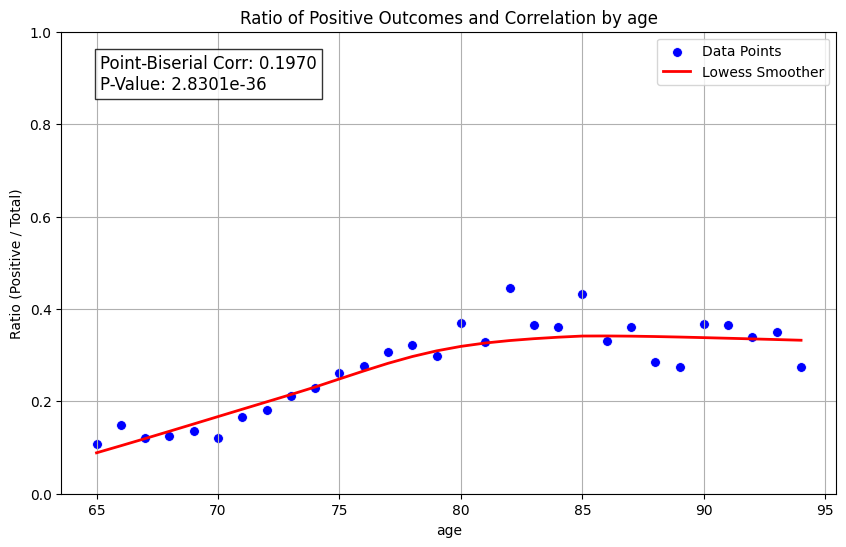

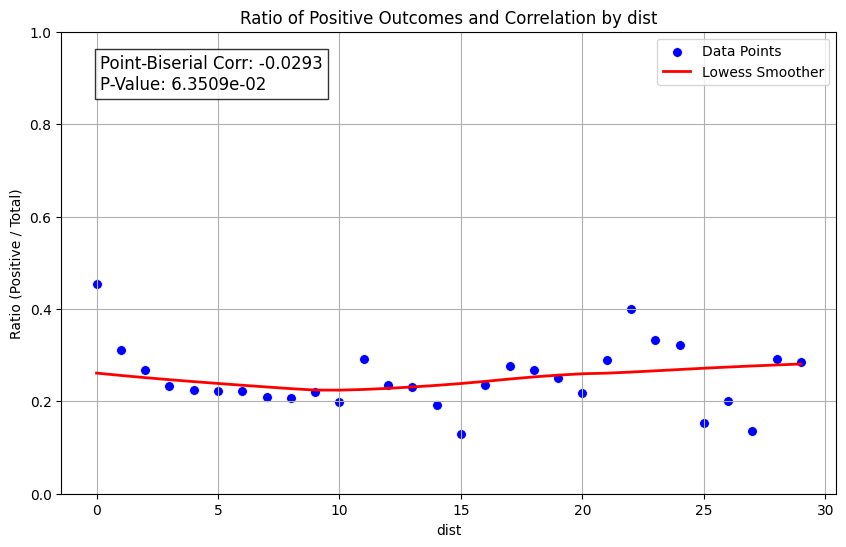

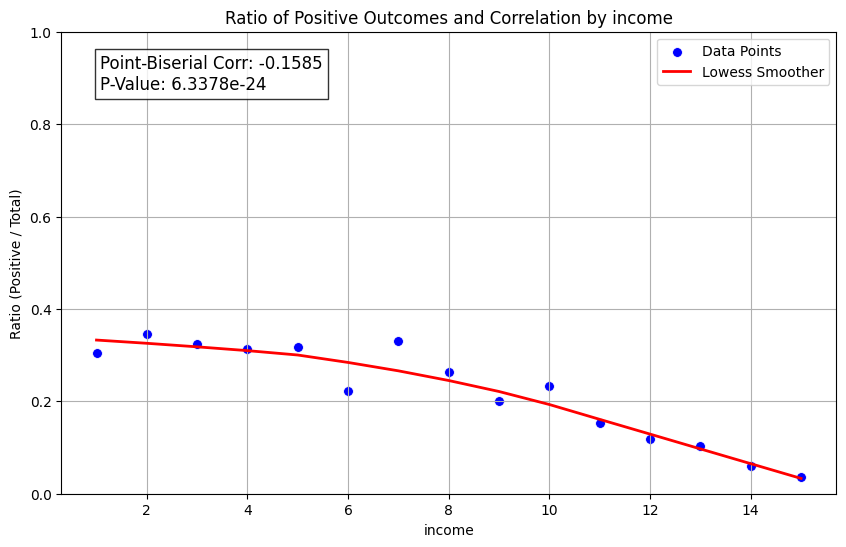

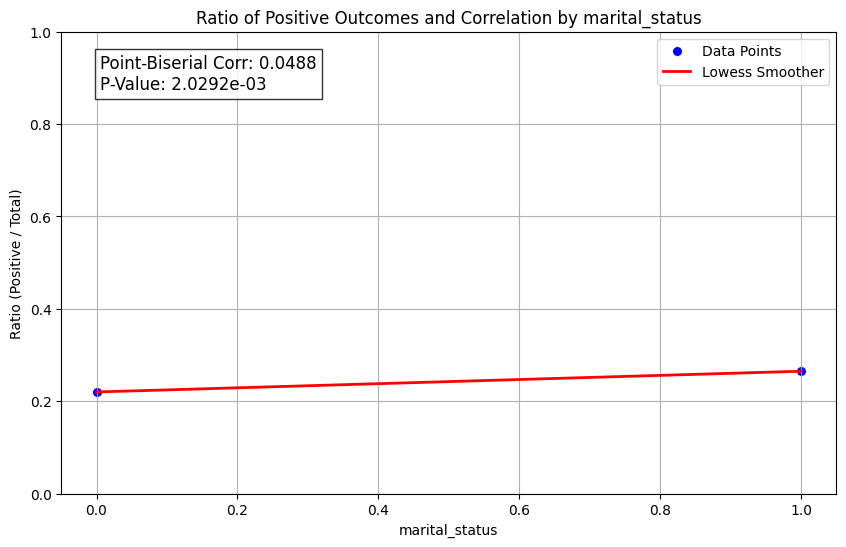

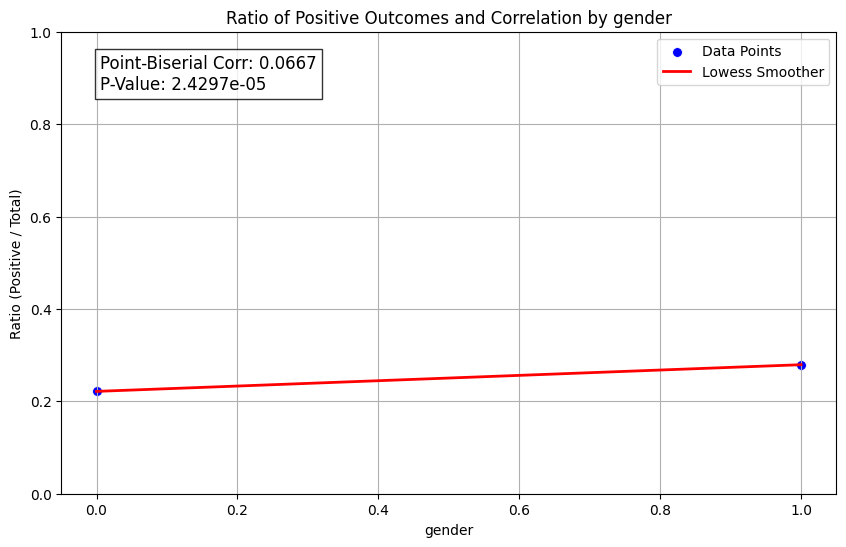

In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

def plot_ratio_positive_negative_with_corr(df, continuous_var, categorical_var='target', positive_value=1, negative_value=0):
    """
    Plot the ratio of positive to total outcomes for a continuous variable with a smoother
    and display the correlation coefficient.
    
    Parameters:
    - df: DataFrame containing the data.
    - continuous_var: Name of the continuous predictor column.
    - categorical_var: Name of the binary target column.
    - positive_value: Value representing positive outcomes (default=1).
    - negative_value: Value representing negative outcomes (default=0).
    """
    # Group by continuous variable and category to get counts
    grouped = df.groupby([continuous_var, categorical_var]).size().reset_index(name='count')
    
    # Pivot so we have positive and negative counts
    pivot = grouped.pivot(index=continuous_var, columns=categorical_var, values='count').fillna(0)
    
    # Extract positive and total counts
    positive_counts = pivot[positive_value] if positive_value in pivot.columns else 0
    total_counts = positive_counts + pivot[negative_value] if negative_value in pivot.columns else positive_counts

    # To avoid division by zero, add a small epsilon
    epsilon = 1e-9
    ratio = positive_counts / (total_counts + epsilon)

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        continuous_var: ratio.index,
        'ratio_positive_negative': ratio.values
    })
    
    # Calculate Point-Biserial Correlation
    correlation, p_value = pointbiserialr(df[continuous_var], df[categorical_var])
    
    # Plot the points and smoother
    plt.figure(figsize=(10, 6))
    
    # Scatter plot of ratio points
    sns.scatterplot(x=continuous_var, y='ratio_positive_negative', data=plot_df, color='blue', s=50, label='Data Points')

    # Add a smooth trend line (lowess)
    sns.regplot(x=continuous_var, y='ratio_positive_negative', data=plot_df, 
                scatter=False, lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother')

    # Add the correlation coefficient as text on the plot
    plt.text(0.05, 0.95, f'Point-Biserial Corr: {correlation:.4f}\nP-Value: {p_value:.4e}', 
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    
    # Final plot settings
    plt.title(f'Ratio of Positive Outcomes and Correlation by {continuous_var}')
    plt.xlabel(continuous_var)
    plt.ylabel('Ratio (Positive / Total)')
    plt.ylim(0, 1)  # Ratio ranges between 0 and 1
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
plot_ratio_positive_negative_with_corr(data, 'age', 'target', positive_value=1, negative_value=0)
plot_ratio_positive_negative_with_corr(data, 'dist', 'target', positive_value=1, negative_value=0)
plot_ratio_positive_negative_with_corr(data, 'income', 'target', positive_value=1, negative_value=0)
plot_ratio_positive_negative_with_corr(data, 'marital_status', 'target', positive_value=1, negative_value=0)
plot_ratio_positive_negative_with_corr(data, 'gender', 'target', positive_value=1, negative_value=0)


For the Logistic Regression model to be valid, the relationship between these variables does not need to be linear, but the relationship does need to have predictive power. If there isn't a clear predictor and response relationship between these these variabels and probability of posative outcome, this really isn't the right model to represent the relationship between these these variables and weither or not someone will actually respond to an advertising campaign. 

For the sake of demonstraighting why this is important, we will produce an ROC curve and a lift chart. 

ROC curve

keep in mind the Logistic Regression model is being trained and tested on the entire data set for the sake of demonstration.

Optimization terminated successfully.
         Current function value: 0.527865
         Iterations 6


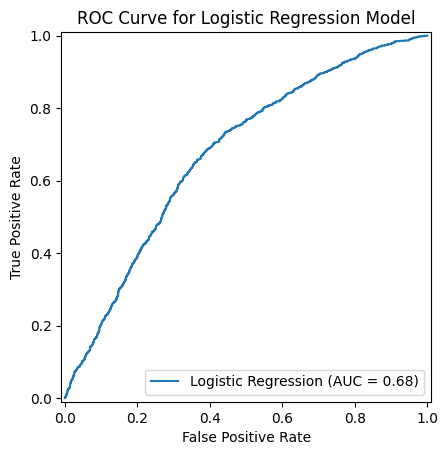

In [268]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

# Predictors and Response
predictor = data[['age', 'income', 'dist', 'gender', 'marital_status']]
response = data['target']

# Add constant for intercept
predictor_with_const = sm.add_constant(predictor)

# Fit logistic regression model
logit_model = sm.Logit(response, predictor_with_const)
result = logit_model.fit()

# Predict probabilities for the positive class
response_probs = result.predict(predictor_with_const)  # Use .predict() in statsmodels

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(response, response_probs)

# Plot ROC Curve
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name="Logistic Regression").plot()

# Show the plot
plt.title("ROC Curve for Logistic Regression Model")
plt.show()

68% AUC, not great but not terrible. So far everything is fine. 

Optimization terminated successfully.
         Current function value: 0.527865
         Iterations 6


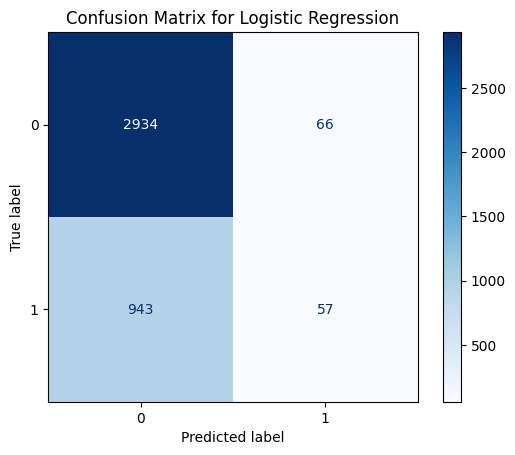

Model Performance Metrics:
Accuracy:  0.7478
Precision: 0.4634
Recall:    0.0570
F1-Score:  0.1015


In [269]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Predictors and Response
predictor = data[['age', 'income', 'dist', 'gender', 'marital_status']]
response = data['target']

# Add constant for intercept
predictor_with_const = sm.add_constant(predictor)

# Fit logistic regression model
logit_model = sm.Logit(response, predictor_with_const)
result = logit_model.fit()

# Predict probabilities for the positive class
predicted_probs = result.predict(predictor_with_const)

# Convert probabilities to binary predictions (threshold = 0.5)
predicted_classes = np.where(predicted_probs >= 0.5, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(response, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Compute associated statistics
accuracy = accuracy_score(response, predicted_classes)
precision = precision_score(response, predicted_classes)
recall = recall_score(response, predicted_classes)
f1 = f1_score(response, predicted_classes)

# Print statistics
print("Model Performance Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Also the accuracy looks good too having being 75%, until you see the recall, which is 0.0570. 

This means that only 5.7% of the posative outcomes were correctly predicted. 

Consequently, our lift chart looks like this. 

Optimization terminated successfully.
         Current function value: 0.527865
         Iterations 6
Lift Chart Data:


,Lift Curve,Baseline Curve,diff
0,0.0,0.0,0.0
1,15.9,11.5,4.4
2,31.6,21.7,9.9
3,46.2,30.8,15.4
4,61.2,41.0,20.2
5,71.6,50.0,21.6
6,79.0,58.9,20.1
7,85.8,68.0,17.8
8,91.8,78.3,13.5
9,97.3,88.2,9.1


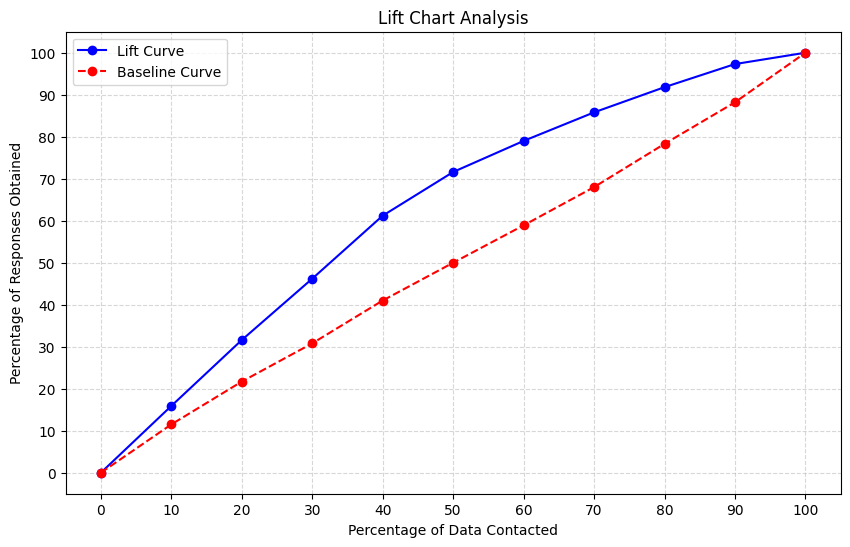

Top rows of sorted data (by predicted probabilities):


,id,age,dist,income,gender,marital_status,target,predicted_probs
3917,3918,94,1,2,1,1,0,0.648670
2393,2394,94,2,2,1,1,1,0.645755
442,443,94,3,2,1,1,1,0.642830
862,863,90,2,1,1,1,0,0.628367
460,461,92,1,2,1,1,1,0.627109


Top rows of shuffled data (random order):


,id,age,dist,income,gender,marital_status,target,predicted_probs
0,556,77,5,11,0,0,0,0.111251
1,3492,82,3,11,1,1,1,0.273661
2,528,80,3,11,0,1,0,0.186317
3,3926,73,1,3,1,0,0,0.285578
4,2990,69,5,2,1,1,0,0.353224


In [270]:

import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def lift_chart(data_sorted, data):
    """
    Computes and plots the lift chart and baseline curve.

    Parameters:
    - data_sorted: DataFrame sorted by predicted probabilities (descending order)
    - data: Original DataFrame for baseline curve computation

    Returns:
    - lift_chart_data: DataFrame containing the lift and baseline curve values
    """
    # Step 1: Total number of positive responses
    sum_responses = data_sorted['target'].sum()

    # Step 2: Initialize lists for lift curve and baseline curve
    lift_curve = []
    baseline_curve = []

    # Step 3: Compute lift and baseline curves across 0%-100% (in 10% increments)
    n_rows = len(data_sorted)

    for i in range(11):  # i from 0 to 10
        cutoff = int((i / 10) * n_rows)  # Calculate the number of rows for the given percentile
        
        # Lift Curve: Percentage of positive responses in top percentile
        lift_percentage = data_sorted.iloc[:cutoff]['target'].sum() / sum_responses * 100
        lift_curve.append(lift_percentage)
        
        # Baseline Curve: Random sampling of the same size from unsorted data
        baseline_percentage = data.iloc[:cutoff]['target'].sum() / sum_responses * 100
        baseline_curve.append(baseline_percentage)

    # Step 4: Create a DataFrame to store lift and baseline curves
    lift_chart_data = pd.DataFrame({
        'Lift Curve': lift_curve,
        'Baseline Curve': baseline_curve
    })

    lift_chart_data['diff'] = lift_chart_data['Lift Curve'] - lift_chart_data['Baseline Curve']

    # Step 5: Display the resulting lift chart data
    print("Lift Chart Data:")
    display(lift_chart_data)

    # Step 6: Plot the Lift and Baseline curves
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(0, 100, 11), lift_chart_data['Lift Curve'], label='Lift Curve', color='blue', marker='o')
    plt.plot(np.linspace(0, 100, 11), lift_chart_data['Baseline Curve'], label='Baseline Curve', color='red', linestyle='--', marker='o')

    # Customize the plot
    plt.title('Lift Chart Analysis')
    plt.xlabel('Percentage of Data Contacted')
    plt.ylabel('Percentage of Responses Obtained')
    plt.xticks(np.linspace(0, 100, 11))
    plt.yticks(np.linspace(0, 100, 11))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()







import statsmodels.api as sm
import pandas as pd

# Predictor and response variables
predictor = data[['age', 'income', 'dist', 'gender', 'marital_status']]
response = data['target']

# Add constant for intercept
predictor_with_const = sm.add_constant(predictor)

# Fit logistic regression model
logit_model = sm.Logit(response, predictor_with_const)
result = logit_model.fit()

# Predict probabilities for the positive class
data['predicted_probs'] = result.predict(predictor_with_const)

# Step 1: Sort the data by predicted probabilities in descending order
data_sorted = data.sort_values(by='predicted_probs', ascending=False)

# Step 2: Shuffle the data randomly
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 3: Call the lift_chart function
lift_chart(data_sorted, data_shuffled)

# Step 4: Display the top rows for both sorted and shuffled DataFrames
print("Top rows of sorted data (by predicted probabilities):")
display(data_sorted.head())

print("Top rows of shuffled data (random order):")
display(data_shuffled.head())

the lift curve is the cumulative percentage of all the posative outcomes sampled for each 10% of the data set. This tests how good our model is becuase the data the lift chart uses is ordered from greatest probability of posative outcome to least probability of posative outcome. When we build a better model next, you will see the differnece. 

notice how the lift chart is best in the middle of the interval, such that the most responses are yeilded where the predicted probability of posative outcome is furthest away form it's greatest and least. What this means is that the true predictor and response relationship is exactly not represneted by the model as where teh probabilites are at their least and greatest is when outcomes are most close to being selected at random.

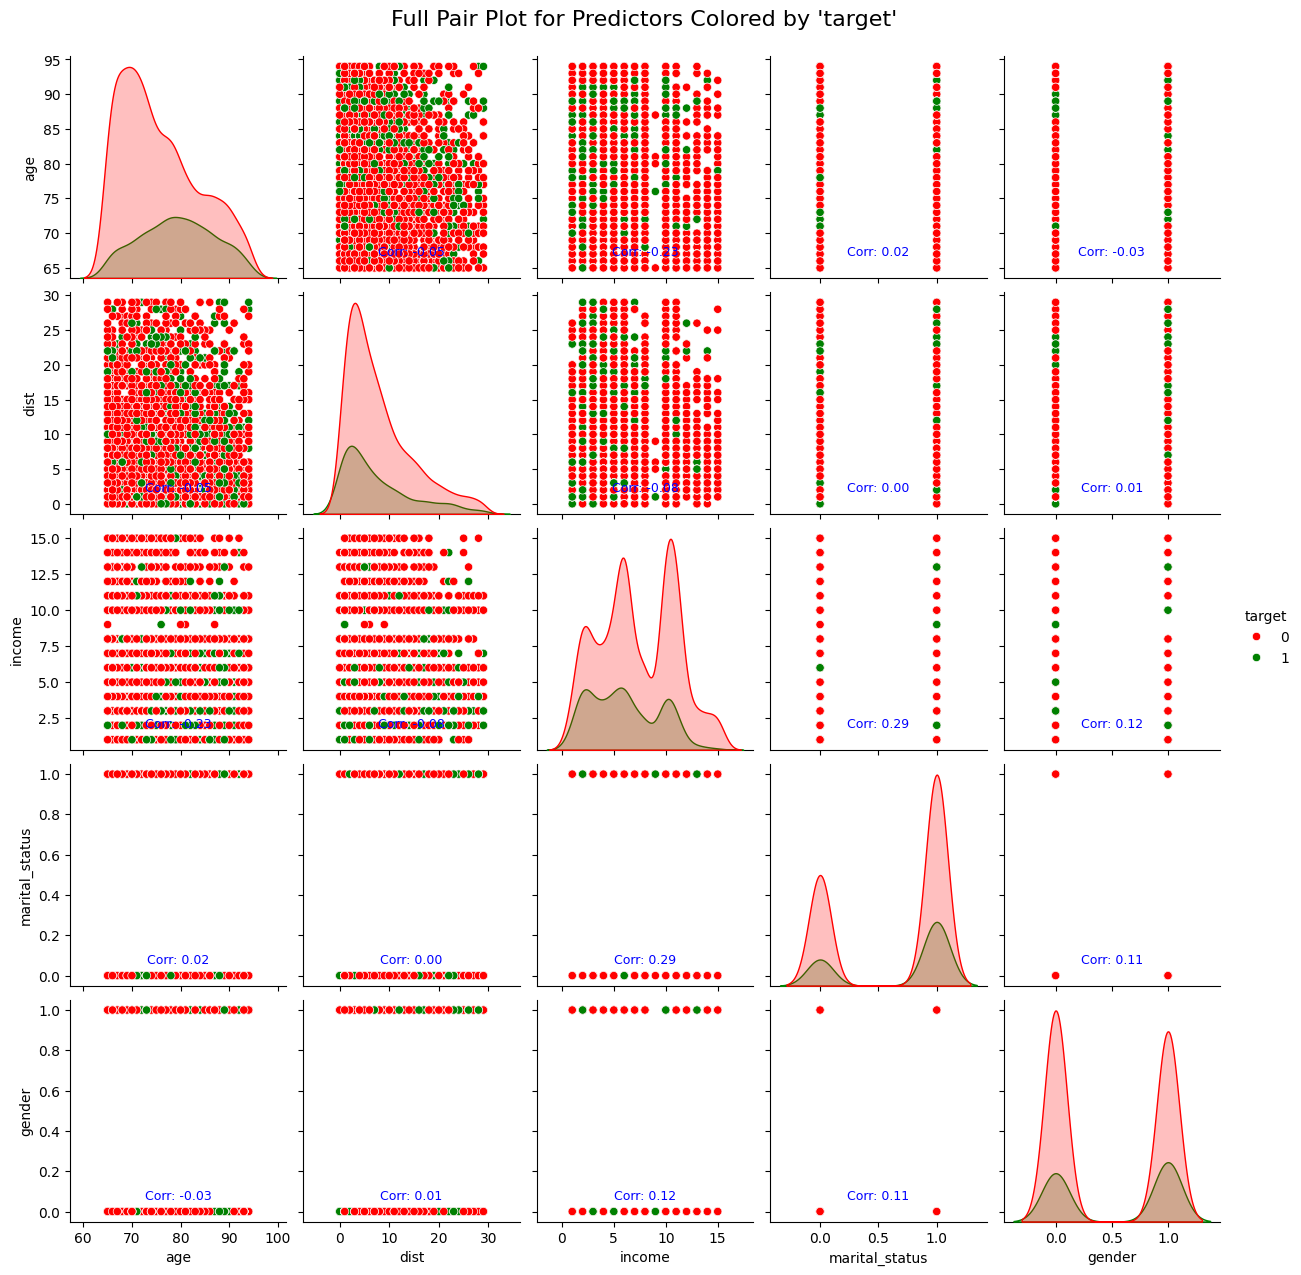

In [271]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_full_pairplot_with_corr_binary_target(df, continuous_vars, target_var='target', positive_value=1, negative_value=0):
    """
    Generate a Seaborn pair plot with correlation coefficients annotated on the scatter plots,
    showing a full matrix, and color-coded by a binary target variable.

    Parameters:
    - df: DataFrame containing the data.
    - continuous_vars: List of continuous variable column names.
    - target_var: Name of the binary target column (default='target').
    - positive_value: Value representing positive outcomes (default=1).
    - negative_value: Value representing negative outcomes (default=0).
    """
    # Filter DataFrame for the required columns
    pairplot_data = df[continuous_vars + [target_var]].copy()
    
    # Ensure the target variable is categorical for coloring
    pairplot_data[target_var] = pairplot_data[target_var].astype('category')
    
    # Calculate pairwise correlations
    correlation_matrix = pairplot_data[continuous_vars].corr()
    
    # Create the pair plot
    g = sns.pairplot(
        pairplot_data,
        hue=target_var,
        palette={positive_value: 'green', negative_value: 'red'},
        diag_kind='kde',
        corner=False  # Full matrix
    )
    
    # Annotate correlation coefficients
    for i, row_var in enumerate(continuous_vars):
        for j, col_var in enumerate(continuous_vars):
            if i != j:  # Skip diagonal
                # Get the current axis
                ax = g.axes[i, j]
                # Get the correlation value
                corr = correlation_matrix.loc[row_var, col_var]
                # Annotate the correlation on the scatter plot
                ax.annotate(
                    f"Corr: {corr:.2f}",
                    xy=(0.5, 0.1),
                    xycoords="axes fraction",
                    ha="center",
                    fontsize=9,
                    color="blue"
                )
    
    # Add a title for context
    plt.suptitle(f"Full Pair Plot for Predictors Colored by '{target_var}'", y=1.02, fontsize=16)
    plt.show()

# Continuous variables and target variable
continuous_vars = ['age', 'dist', 'income', 'marital_status', 'gender']
target_var = 'target'

# Call the function with the DataFrame
plot_full_pairplot_with_corr_binary_target(data, continuous_vars, target_var, positive_value=1, negative_value=0)

we're not seeing any kind of predictor response relationship for posative outcome within the relationships of the predictor vairables like we would need to build a logistic model with predictive power. 

Now we build a model more suited to this kind of data, a Random Forest model. 

Accuracy: 0.67625

Confusion Matrix:
 [[490  93]
 [166  51]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.84      0.79       583
           1       0.35      0.24      0.28       217

    accuracy                           0.68       800
   macro avg       0.55      0.54      0.54       800
weighted avg       0.64      0.68      0.65       800



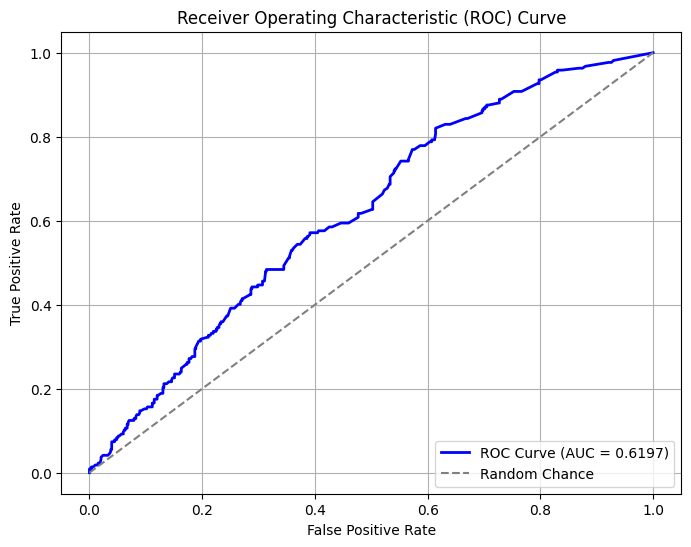

In [272]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, RocCurveDisplay
)

def random_forest_model_with_roc(data, predictors, target, test_size=0.2, random_state=42):
    """
    Train and evaluate a Random Forest model and produce a ROC chart.

    Parameters:
    - data: Pandas DataFrame containing predictors and target.
    - predictors: List of column names used as features.
    - target: Name of the target column.
    - test_size: Proportion of the data to use for testing (default 0.2).
    - random_state: Random state for reproducibility (default 42).

    Returns:
    - model: Trained RandomForestClassifier model.
    """
    # Step 1: Split the data into train and test sets
    X = data[predictors]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Step 2: Initialize and train the Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=random_state)
    model.fit(X_train, y_train)

    # Step 3: Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Step 4: Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)

    # Step 5: Generate and plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    return model

# Example Usage:
predictors = ['age', 'income', 'dist', 'gender', 'marital_status']
target = 'target'
trained_model = random_forest_model_with_roc(data, predictors, target)

The accuracy is inferior, but this time this accuracy is was from the model being evaluated on data from which it was not trained on.

Despite this, it's recall for posative outcomes is vastly superior. 

Lift Chart for Random Forest Model:
Lift Chart Data:


,Lift Curve,Baseline Curve,diff
0,0.0,0.0,0.0
1,37.7,11.5,26.2
2,72.8,21.7,51.1
3,88.6,30.8,57.8
4,91.9,41.0,50.9
5,95.2,50.0,45.2
6,96.6,58.9,37.7
7,98.0,68.0,30.0
8,99.1,78.3,20.8
9,99.4,88.2,11.2


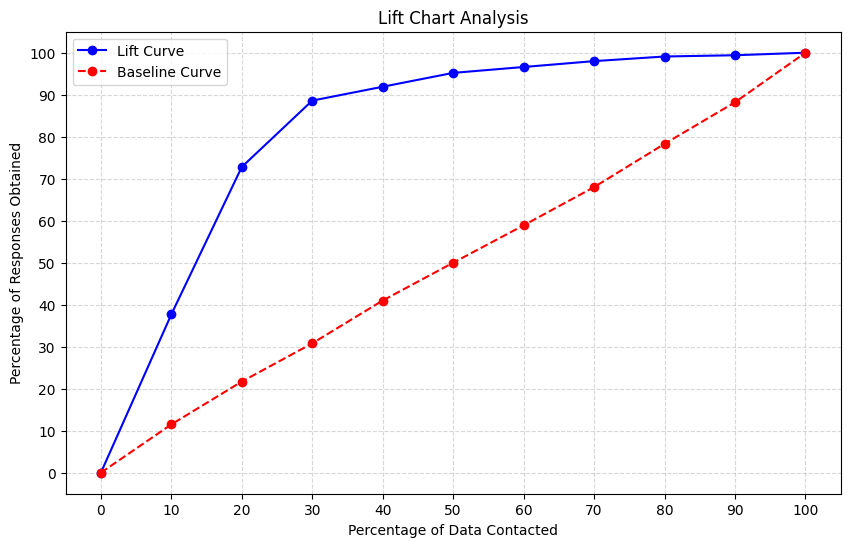

Top rows of sorted data (by predicted probabilities):


,id,age,dist,income,gender,marital_status,target,predicted_probs
2726,2727,79,0,2,0,1,1,0.99
2071,2072,79,0,2,0,1,1,0.99
1016,1017,77,5,11,1,1,1,0.98
246,247,85,0,6,1,1,1,0.98
171,172,77,5,11,1,1,1,0.98


Top rows of shuffled data (random order):


,id,age,dist,income,gender,marital_status,target,predicted_probs
0,556,77,5,11,0,0,0,0.050
1,3492,82,3,11,1,1,1,0.080
2,528,80,3,11,0,1,0,0.250
3,3926,73,1,3,1,0,0,0.205
4,2990,69,5,2,1,1,0,0.285


In [273]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Train the Random Forest model and predict probabilities
predictors = ['age', 'income', 'dist', 'gender', 'marital_status']
target = 'target'

# Split data into training and test sets
X = data[predictors]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict probabilities for the positive class on the **entire dataset**
data['predicted_probs'] = rf_model.predict_proba(X)[:, 1]

# Step 2: Sort the data by predicted probabilities in descending order
data_sorted_rf = data.sort_values(by='predicted_probs', ascending=False)

# Step 3: Shuffle the data randomly
data_shuffled_rf = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 4: Call the lift_chart function
print("Lift Chart for Random Forest Model:")
lift_chart(data_sorted_rf, data_shuffled_rf)

# Step 5: Display the top rows for both sorted and shuffled DataFrames
print("Top rows of sorted data (by predicted probabilities):")
display(data_sorted_rf.head())

print("Top rows of shuffled data (random order):")
display(data_shuffled_rf.head())

Thus with the random forest model being evaluated on data from which it was not trained, by contacting only 30% of the customer base it yeilded 90% of all the responses. 